# Bushifire Risk Analysis

### Data preprocessing:

Import all the package that we need and set the path of our dataset

In [49]:
from __future__ import (absolute_import, division, print_function)
import os
import json
import requests

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import scipy.stats

data_path = "./data1"

Read all the dataset that we need

In [2]:
data_business = pd.read_csv(os.path.join(data_path, "BusinessStats.csv"))
data_neighbour = pd.read_csv(os.path.join(data_path, "Neighbourhoods.csv"))
data_statistical = pd.read_csv(os.path.join(data_path, "StatisticalAreas.csv"))
shape = gpd.read_file(os.path.join(data_path, "RFSNSW_BFPL_small.shp"))
boundary = gpd.read_file(os.path.join(data_path, "SA2_2016_AUST.shp"))

Doing data cleaning, since our formula need logistic function and z-score, we decided to drop those column that with Null value instead of convert them into 0 value.

In [3]:
data_business1 = data_business.drop_duplicates()
data_business1 = data_business1.dropna(subset = ["number_of_businesses", "health_care_and_social_assistance", "public_administration_and_safety"])
data_neighbour1 = data_neighbour.drop_duplicates()
data_neighbour1 = data_neighbour1.dropna(subset = ["population", "number_of_dwellings", "land_area"])
data_neighbour1 = data_neighbour1[data_neighbour1.land_area != 0]
data_statistical1 = data_statistical.drop_duplicates()
data_statistical1 = data_statistical1.dropna()
shape1 = shape.drop_duplicates()
shape1 = shape1.dropna()
boundary1 = boundary.drop_duplicates()
boundary1 = boundary1[boundary1.geometry != None]

rename columns' name to fit our schema

In [4]:
data_business1.rename(columns = {'accommodation_and_food_services':'accommodation_and_food'}, inplace = True)
data_neighbour1.rename(columns = {'number_of_dwellings':'dwellings', 
                                  'number_of_businesses':'businesses', 
                                  'median_annual_household_income':'median_income'}, inplace = True)
shape1.columns = shape1.columns.str.lower()
boundary1.columns = ["sa2_main16", "sa2_5dig16", "sa2_name16", "sa3_code", "sa3_name", "sa4_code", "sa4_name", 
                     "gcc_code", "gcc_name", "ste_code", "ste_name", "areasqkm16", "geometry"]

convert number with "," to the format of integer

In [5]:
data_neighbour1["population"] = data_neighbour1["population"].str.replace(",", "").astype(int)
data_neighbour1["dwellings"] = data_neighbour1["dwellings"].str.replace(",", "").astype(int)

Since we choose area_id in statistical_area as primary key, we filter out all the area_id and 9 digits sa2 data that not in the statistical_area

In [6]:
# statistical_area & businesses
common = list(set(data_statistical1.area_id).intersection(set(data_business1.area_id)))
data_business1 = data_business1[data_business1["area_id"].isin(common)]
# statistical_area & neighbourhood
common = list(set(data_statistical1.area_id).intersection(set(data_neighbour1.area_id)))
data_neighbour1 = data_neighbour1[data_neighbour1["area_id"].isin(common)]
# statistical_area & sa2 data
common = list(set(data_statistical1.area_id).intersection(set(boundary1.sa2_main16.astype(int))))
boundary1 = boundary1[boundary1["sa2_main16"].astype(int).isin(common)]

Create function to connect sql db

In [7]:
data_path = "."

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        HOST       = db_conn_dict['host']
        DB_USER    = db_conn_dict['user']
        DB_PW      = db_conn_dict['password']
        DEFAULT_DB = db_conn_dict['user']

        try:
            db = create_engine('postgres+psycopg2://'+DB_USER+':'+DB_PW+'@'+HOST+'/'+DEFAULT_DB, echo=False)
            conn = db.connect()
            print('connected')
        except Exception as e:
            print("unable to connect to the database")
            print(e)
        return db,conn

credfilepath = os.path.join(data_path, "data2x01_db.json")

In [59]:
db,conn = pgconnect(credfilepath)

connected


Create function to execute sql command

In [9]:
def pgexecute( conn, sqlcmd, args=None, msg='', silent=False ):
    """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
    retval = False
    result_set = None

    try:
        if args is None:
            result_set = conn.execute(sqlcmd).fetchall()
        else:
            result_set = conn.execute(sqlcmd, args).fetchall()

        if silent == False: 
            print("success: " + msg)
            for record in result_set:
                print(record)
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval

def pgquery( conn, sqlcmd, args=None, silent=False ):
    """ utility function to execute some SQL query statement
    can take optional arguments to fill in (dictionary)
    will print out on screen the result set of the query
    error and transaction handling built-in """
    retdf = pd.DataFrame()
    retval = False
    try:
        if args is None:
            retdf = pd.read_sql_query(sqlcmd,conn)
        else:
            retdf = pd.read_sql_query(sqlcmd,conn,params=args)
        if silent == False:
            print(retdf.shape)
            print(retdf.to_string())
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval,retdf

Build schema

In [11]:
# rest table if needed
conn.execute("DROP TABLE IF EXISTS neighbourhoods")
conn.execute("DROP TABLE IF EXISTS businessstats")
conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")
conn.execute("DROP TABLE IF EXISTS statisticalareas")

# build schema
statisticalareas_schema = """CREATE TABLE IF NOT EXISTS statisticalareas (
                         area_id            INTEGER     PRIMARY KEY,
                         area_name          VARCHAR(50) NOT NULL,
                         parent_area_id     INTEGER
                   )"""

neighbourhoods_schema = """CREATE TABLE IF NOT EXISTS neighbourhoods (
                         area_id            INTEGER   PRIMARY KEY REFERENCES statisticalareas(area_id),
                         area_name          VARCHAR(50)   UNIQUE NOT NULL, 
                         land_area          NUMERIC,
                         population         INTEGER,
                         dwellings          INTEGER,
                         businesses         INTEGER,
                         median_income      INTEGER,
                         avg_monthly_rent   INTEGER     
                   )"""

businessstats_schema = """CREATE TABLE IF NOT EXISTS businessstats (
                         area_id                            INTEGER    PRIMARY KEY REFERENCES statisticalareas(area_id),
                         area_name                          VARCHAR(50)   UNIQUE NOT NULL,
                         number_of_businesses               INTEGER,
                         accommodation_and_food             INTEGER,
                         retail_trade                       INTEGER,
                         agriculture_forestry_and_fishing   INTEGER,
                         health_care_and_social_assistance  INTEGER,
                         public_administration_and_safety   INTEGER,
                         transport_postal_and_warehousing   INTEGER
                   )"""

rfsnsw_bfpl_schema = """CREATE TABLE IF NOT EXISTS rfsnsw_bfpl (
                         category     NUMERIC   NOT NULL, 
                         shape_leng   NUMERIC   NOT NULL,
                         shape_area   NUMERIC   NOT NULL,
                         geom         GEOMETRY(POINT, 4283)    
                   )"""

sa2_2016_aust_schema = """CREATE TABLE IF NOT EXISTS sa2_2016_aust (
                         sa2_main16   INTEGER        PRIMARY KEY    REFERENCES statisticalareas(area_id),
                         sa2_5dig16   INTEGER        UNIQUE NOT NULL,
                         sa2_name16   VARCHAR(50)    UNIQUE NOT NULL,
                         sa3_code     INTEGER,
                         sa3_name     VARCHAR(50),
                         sa4_code     INTEGER,
                         sa4_name     VARCHAR(50),
                         gcc_code     CHAR(5),
                         gcc_name     VARCHAR(50),
                         ste_code     INTEGER,
                         ste_name     VARCHAR(50),
                         areasqkm16   NUMERIC,
                         geom         GEOMETRY(MULTIPOLYGON,4283) 
                   )"""



# execute shcema in db
conn.execute(statisticalareas_schema)
conn.execute(neighbourhoods_schema)
conn.execute(businessstats_schema)
conn.execute(rfsnsw_bfpl_schema)
conn.execute(sa2_2016_aust_schema)

# check if it's successfully build
print(db.table_names())

['spatial_ref_sys', 'statisticalareas', 'neighbourhoods', 'businessstats', 'rfsnsw_bfpl', 'sa2_2016_aust']


Create function that use to do the coversion, from python shapely types to WKT format

In [12]:
def create_wkt_point_element(geom,srid):
    return WKTElement(geom.wkt, srid)

def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

srid = 4283

Convert geo data from two tables to WKT format

In [13]:
shapeWkCpy = shape1.copy()
shapeWkCpy['geom'] = shapeWkCpy['geometry'].apply(lambda x: create_wkt_point_element(geom=x,srid=srid))
shapeWkCpy = shapeWkCpy.drop(columns="geometry")
shapeWkCpy.columns= shapeWkCpy.columns.str.lower()

In [14]:
boundaryWkCpy = boundary1.copy()
boundaryWkCpy['geom'] = boundaryWkCpy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
boundaryWkCpy = boundaryWkCpy.drop(columns="geometry")
boundaryWkCpy

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geom
22,101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,9035.1221,MULTIPOLYGON (((149.096311837 -34.418943888999...
27,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,MULTIPOLYGON (((151.4137275700001 -33.46559324...
28,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,MULTIPOLYGON (((151.3539836770001 -33.49854010...
29,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,767.9512,MULTIPOLYGON (((151.204595054 -33.532982995999...
30,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,33.7934,MULTIPOLYGON (((151.3679483220001 -33.43822416...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,128021537,11537,Royal National Park,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,139.3336,MULTIPOLYGON (((151.071650994 -34.057945007999...
572,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,7.7547,MULTIPOLYGON (((151.05049439 -34.0200584319999...
573,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8.9538,MULTIPOLYGON (((150.9956780320001 -34.05362100...
574,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,3.8436,MULTIPOLYGON (((151.0395427830001 -34.04175791...


Put all the needed data into sql db

In [15]:
data_statistical1.to_sql("statisticalareas", con=conn, if_exists='append',index=False)
data_business1.to_sql("businessstats", con=conn, if_exists='append',index=False)
data_neighbour1.to_sql("neighbourhoods", con=conn, if_exists='append',index=False)
shapeWkCpy.to_sql("rfsnsw_bfpl", con=conn, if_exists='append',index=False, 
             dtype={'geom': Geometry('POINT', 4283)})
boundaryWkCpy.to_sql("sa2_2016_aust", con=conn, if_exists='append',index=False, 
             dtype={'geom': Geometry('MULTIPOLYGON', 4283)})

Create spatial index on rfsnsw_bfpl, sa2_2016_aust

In [16]:
index_command = "CREATE INDEX shape_idx ON rfsnsw_bfpl USING GIST (geom)"
conn.execute("DROP INDEX IF EXISTS shape_idx")
conn.execute(index_command)

index_command = "CREATE INDEX boundary_idx ON sa2_2016_aust USING GIST (geom)"
conn.execute("DROP INDEX IF EXISTS boundary_idx")
conn.execute(index_command)

Create a View that include the area_id of Greater Sydney

In [17]:
query = """ CREATE VIEW NSWAreaID AS
            SELECT area_id 
            FROM statisticalareas
            WHERE parent_area_id IN (SELECT area_id
                                     FROM statisticalareas
                                     WHERE parent_area_id IN (SELECT area_id
                                                              FROM statisticalareas
                                                              WHERE parent_area_id = 10 or parent_area_id = 11))"""
conn.execute(query)

z-socre of population density

In [18]:
query = """ CREATE VIEW PopulationDensity AS
            SELECT CAST(CAST(population AS FLOAT)/ CAST(areasqkm16 AS FLOAT) AS FLOAT) AS population_density,
                   area_id
            FROM neighbourhoods join NSWAreaID USING(area_id) join sa2_2016_aust ON (area_id = sa2_main16)"""
conn.execute(query)

query = """ CREATE VIEW PopulationDensity_zscore AS
            SELECT ABS((population_density - average)) / std AS z_score, area_id
            FROM PopulationDensity PD1, 
                 (SELECT AVG(population_density) AS average,
                         STDDEV(population_density) AS std
                  FROM PopulationDensity) PD2"""
conn.execute(query)

z-score of dwelling density

In [19]:
query = """ CREATE VIEW DwellingDensity AS
            SELECT CAST(CAST(dwellings AS FLOAT)/ CAST(areasqkm16 AS FLOAT) AS FLOAT) AS dwelling_density,
                   area_id
            FROM neighbourhoods join NSWAreaID USING(area_id) join sa2_2016_aust ON (area_id = sa2_main16)"""
conn.execute(query)

query = """ CREATE VIEW DwellingDensity_zscore AS
            SELECT (dwelling_density - average) / std AS z_score, area_id
            FROM DwellingDensity PD1, 
                 (SELECT AVG(dwelling_density) AS average,
                         STDDEV(dwelling_density) AS std
                  FROM DwellingDensity) PD2"""
conn.execute(query)

z-score of businesses density

In [20]:
query = """ CREATE VIEW BusinessesDensity AS
            SELECT CAST(CAST(number_of_businesses AS FLOAT)/ CAST(areasqkm16 AS FLOAT) AS FLOAT) AS businesses_density,
                   area_id
            FROM neighbourhoods join NSWAreaID USING(area_id) join businessstats using(area_id) join sa2_2016_aust ON (area_id = sa2_main16)"""
conn.execute(query)

query = """ CREATE VIEW BusinessesDensity_zscore AS
            SELECT (businesses_density - average) / std AS z_score, area_id
            FROM BusinessesDensity PD1, 
                 (SELECT AVG(businesses_density) AS average,
                         STDDEV(businesses_density) AS std
                  FROM BusinessesDensity) PD2"""
conn.execute(query)

z-score of assistive service density

In [21]:
query = """ CREATE VIEW AssistiveServiceDensity AS
            SELECT CAST((CAST(health_care_and_social_assistance AS FLOAT) + CAST(public_administration_and_safety AS FLOAT)) / CAST(land_area AS FLOAT) AS FLOAT) AS AssistiveService_density,
                   area_id
            FROM neighbourhoods join NSWAreaID USING(area_id) join businessstats using(area_id)"""
conn.execute(query)

query = """ CREATE VIEW AssistiveServiceDensity_zscore AS
            SELECT (AssistiveService_density - average) / std AS z_score, area_id
            FROM AssistiveServiceDensity PD1, 
                 (SELECT AVG(AssistiveService_density) AS average,
                         STDDEV(AssistiveService_density) AS std
                  FROM AssistiveServiceDensity) PD2"""
conn.execute(query)

z-score of bfpl density

In [39]:
query = """CREATE VIEW bfpl_Sum AS
           SELECT sa.sa2_main16 AS "area_id", rf.category AS "category", 
                  CASE WHEN rf.category = 1.0 THEN 1
                       WHEN rf.category = 2.0 THEN 0.27
                       ELSE 0.3
                  END AS "weight",
                  SUM(shape_area) AS "sum"
           FROM NSWAreaID JOIN sa2_2016_aust sa ON(area_id = sa2_main16) LEFT OUTER JOIN rfsnsw_bfpl rf ON (ST_Contains(sa.geom, rf.geom))
           GROUP BY sa.sa2_main16, rf.category"""
conn.execute(query)


query = """CREATE VIEW bfpl_Density AS
           SELECT area_id, SUM((CAST(COALESCE(sum, '0') AS FLOAT)/ CAST(areasqkm16 AS FLOAT)) * weight) AS "bfpl_density"
           FROM bfpl_Sum join sa2_2016_aust ON (area_id = sa2_main16)
           GROUP BY area_id"""
conn.execute(query)

query = """CREATE VIEW bfpl_Density_zscore AS
           SELECT area_id, (bfpl_density - average) / std AS z_score
           FROM bfpl_Density BD1, 
                 (SELECT AVG(bfpl_density) AS average,
                         STDDEV(bfpl_density) AS std
                  FROM bfpl_Density) BD2"""
conn.execute(query)

z-score of recent hotspot density
Because hotspot Json will update every 10 minutes, everytime re-run the following codes
It will get the newest Json data

In [23]:
conn.execute("DROP VIEW IF EXISTS fire_risk_plot")
conn.execute("DROP VIEW IF EXISTS fire_risk")
conn.execute("DROP VIEW IF EXISTS hotspot_Density_zscore")
conn.execute("DROP VIEW IF EXISTS hotspot_Density")
conn.execute("DROP VIEW IF EXISTS hotspot_Sum")
gxWkCpy_schema = """CREATE TABLE IF NOT EXISTS recent_hotspot (
                         geom   GEOMETRY(POINT, 4283) 
                   )"""

conn.execute(gxWkCpy_schema)

In [24]:
response = requests.get("https://hotspots.dea.ga.gov.au/data/recent-hotspots.json")
web = response.json()

x = pd.DataFrame({'longitude': [],'latitude': []})
j = 0
for i in range(len(web['features'])):
    if (web['features'][i]['properties']['australian_state'] == "NSW"):
        x.loc[j] = {'longitude': web['features'][i]['properties']['longitude'], 'latitude': web['features'][i]['properties']['latitude']}
        j += 1

gx = gpd.GeoDataFrame(
    x, geometry=gpd.points_from_xy(x.longitude, x.latitude))

gxWkCpy = gx.copy()
gxWkCpy['geom'] = gxWkCpy['geometry'].apply(lambda x: create_wkt_point_element(geom=x,srid=srid))
gxWkCpy = gxWkCpy.drop(columns=["geometry", "longitude", "latitude"])
gxWkCpy

,geom
0,POINT (153.0818 -28.9306)
1,POINT (152.5718 -31.7393)
2,POINT (153.0818 -28.9268)
3,POINT (152.5681 -31.7393)
4,POINT (153.1763 -29.4689)
...,...
876,POINT (145.9297 -30.8846)
877,POINT (145.9265 -30.8832)
878,POINT (145.9243 -30.8888)
879,POINT (145.9353 -30.8866)


In [25]:
gxWkCpy.to_sql("recent_hotspot", con=conn, if_exists='append',index=False, 
             dtype={'geom': Geometry('POINT', 4283)})

In [26]:
index_command = "CREATE INDEX hotspot_idx ON recent_hotspot USING GIST (geom)"
conn.execute("DROP INDEX IF EXISTS boundary_idx")
conn.execute(index_command)

In [41]:

query = """CREATE VIEW hotspot_Sum AS
           SELECT sa.sa2_main16 AS "area_id", COUNT(rh.geom) AS hotspot_times
           FROM NSWAreaID JOIN sa2_2016_aust sa ON(area_id = sa2_main16) LEFT OUTER JOIN recent_hotspot rh ON (ST_Contains(sa.geom, rh.geom))
           GROUP BY sa.sa2_main16"""
conn.execute(query)

query = """CREATE VIEW hotspot_Density AS
           SELECT area_id, hotspot_times / CAST(areasqkm16 AS FLOAT) AS "hotspot_density"
           FROM hotspot_Sum join sa2_2016_aust ON (area_id = sa2_main16)"""
conn.execute(query)

query = """CREATE VIEW hotspot_Density_zscore AS
           SELECT area_id, (hotspot_Density - average) / std AS z_score
           FROM hotspot_Density HD1, 
                 (SELECT AVG(hotspot_density) AS average,
                         STDDEV(hotspot_density) AS std
                  FROM hotspot_Density) HD2"""
conn.execute(query)

Fire risk score

In [42]:
query = """CREATE VIEW fire_risk AS
           SELECT area_id, 1/(1 + exp(-(pd.z_score + dd.z_score + bd.z_score + bfd.z_score - ad.z_score + hd.z_score))) AS fire_risk
           FROM PopulationDensity_zscore pd 
                JOIN DwellingDensity_zscore dd USING(area_id) 
                JOIN BusinessesDensity_zscore bd USING(area_id)
                JOIN AssistiveServiceDensity_zscore ad USING(area_id)
                JOIN bfpl_Density_zscore bfd USING(area_id)
                JOIN hotspot_Density_zscore hd USING(area_id)"""
conn.execute(query)

Create view to store the data for mapping

In [43]:
query = """CREATE VIEW fire_risk_plot AS
                SELECT area_id, fire_risk, sa.geom
                FROM fire_risk fr JOIN sa2_2016_aust sa ON(fr.area_id = sa.sa2_main16)"""
conn.execute(query)

Visulisation

<AxesSubplot:>

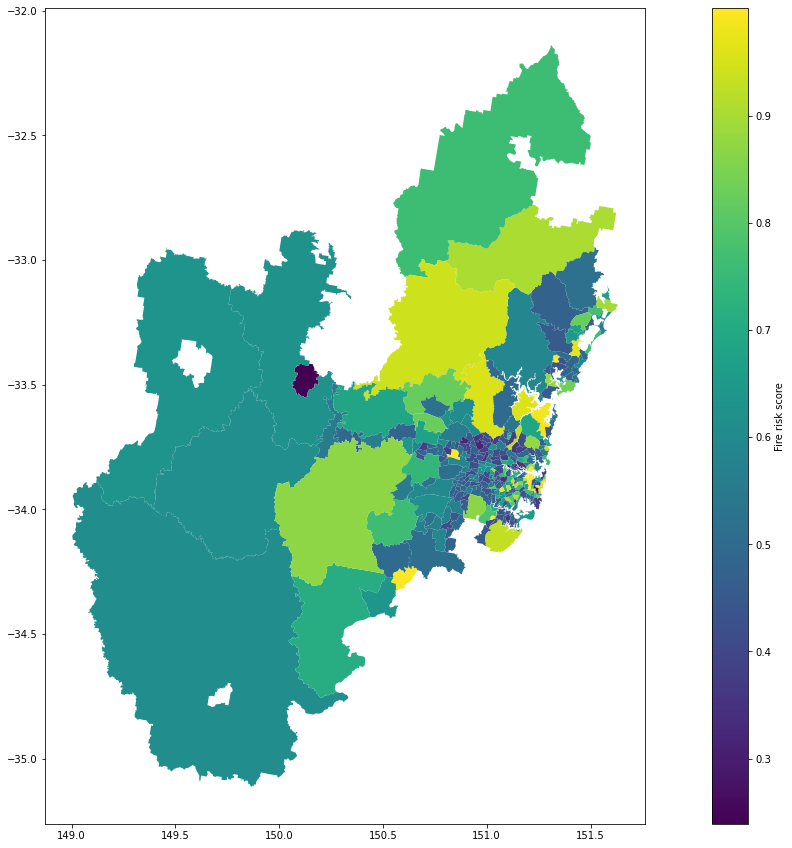

In [44]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams[ "figure.figsize" ] = (15,15)

fire_risk_map = gpd.read_postgis("SELECT * FROM fire_risk_plot", conn)

fig, ax = plt.subplots(1, 1)

fire_risk = make_axes_locatable(ax)

cax = fire_risk.append_axes("right", size="5%", pad=0.1)

fire_risk_map.plot(column='fire_risk', ax=ax, legend=True, legend_kwds={'label': "Fire risk score"}, cax=cax)

Save fire risk score into sql database

In [45]:
query1 = """SELECT area_id, fire_risk
            FROM fire_risk"""

SQL_query1 = pd.read_sql_query(query1, conn)
fire_risk_df1 = pd.DataFrame(SQL_query1, columns = ["area_id", "fire_risk"])
fire_risk_df1
conn.execute("DROP TABLE IF EXISTS fire_risk_score")
fire_risk_schema = """CREATE TABLE IF NOT EXISTS fire_risk_score (
                         area_id     INTEGER   PRIMARY KEY, 
                         fire_risk   NUMERIC   NOT NULL)"""

conn.execute(fire_risk_schema)

fire_risk_df1.to_sql("fire_risk_score", con=conn, if_exists='append',index=False)

pgquery(conn, "SELECT count(*) FROM fire_risk_score")

(1, 1)
   count
0    321


(True,
    count
 0    321)

Read and save area_id, fire_risk, median_income, avg_monthly_rent into df

In [55]:
query = """SELECT area_id, fire_risk, median_income, avg_monthly_rent
           FROM fire_risk JOIN neighbourhoods USING(area_id)
           WHERE median_income IS NOT NULL OR avg_monthly_rent IS NOT NULL"""
retval,retdf = pgquery(conn, query)

SQL_query = pd.read_sql_query(query, conn)
correlation_df = pd.DataFrame(SQL_query, columns = ["area_id", "fire_risk", "median_income", "avg_monthly_rent"])
correlation_df

(315, 4)
       area_id  fire_risk  median_income  avg_monthly_rent
0    101051540   0.612987        62712.0             800.0
1    102011028   0.523152        46996.0            1906.0
2    102011029   0.834223        42621.0            1682.0
3    102011030   0.588379        42105.0            1182.0
4    102011031   0.491166        43481.0            1595.0
5    102011032   0.441377        45972.0            1382.0
6    102011033   0.453931        47896.0            1649.0
7    102011034   0.493441        41642.0            1397.0
8    102011035   0.999809        46660.0            1512.0
9    102011036   0.506696        45762.0            1495.0
10   102011037   0.456893        45966.0            1572.0
11   102011038   0.628191        43171.0            1667.0
12   102011039   0.501789        46422.0            2022.0
13   102011040   0.454023        40252.0            1517.0
14   102011041   0.587308        47295.0            1902.0
15   102011042   0.876844        42481.0       

,area_id,fire_risk,median_income,avg_monthly_rent
0,101051540,0.612987,62712.0,800.0
1,102011028,0.523152,46996.0,1906.0
2,102011029,0.834223,42621.0,1682.0
3,102011030,0.588379,42105.0,1182.0
4,102011031,0.491166,43481.0,1595.0
...,...,...,...,...
310,128021537,0.931065,NaN,1899.0
311,128021538,0.436536,53378.0,1809.0
312,128021607,0.424897,52667.0,1955.0
313,128021608,0.438923,51243.0,2163.0


Find the correlation between fire risk and the median income and rent of a neighbourhood

In [56]:
correlation_df = correlation_df.dropna()

In [57]:
r1, p1 = scipy.stats.pearsonr(correlation_df["fire_risk"], correlation_df["median_income"])
r2, p2 = scipy.stats.pearsonr(correlation_df["fire_risk"], correlation_df["avg_monthly_rent"])
print(r1)
print(p1)
print(r2)
print(p2)

0.051099773438221245
0.3706820338486039
0.08608023784056609
0.13108844034277745


All the tables and views have been created, drop if needed

In [58]:
conn.close()
db.dispose()